**Beginner's gradual improvement / Optiver (Eng/日本語)**

(Updated with (11) insight for popular 'wap'

(Updated with (10) 0.48964 --> 0.43887)

(Credit to Raj Gandhi's notebook for Parallel/delayed operation and adding trade_df. Thanks)

This is the 2nd try for me to join kaggle competition, still a beginner.
The public score has been improved from 2.51735 to 0.48964 after a lot of try and error, but still there are much room to improve... I'd be happy if you have a quick look at this notebook and get a slice of findings about how the score was improved with what operation.. 

今回が２回目のコンペ参加、まだまだ駆け出し。このコンペもかなり苦労してスコアを2.51735→0.43887まで伸ばしたけれど、まだまだ改善の余地あり。。何をしたらどれだけ改善したかの参考程度にご覧いただければ幸いです。

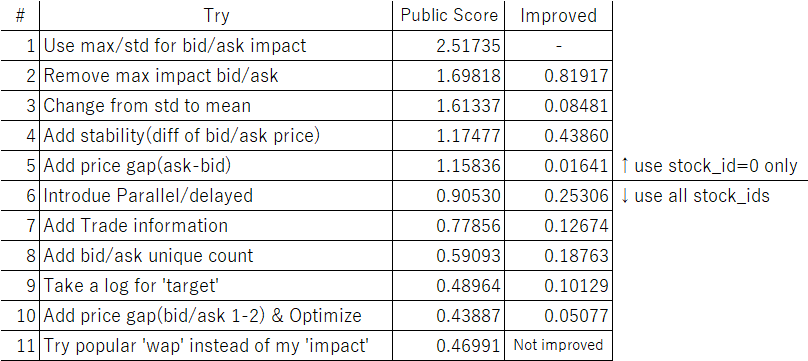


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed

from sklearn.model_selection import KFold
import lightgbm as lgbm

**(1)** First of all, think about "Volatility". Refering to the old textbook on Option dealing I bought in the past, Volatility means 'how easily price changes in the market'. It seems there are 2 kinds of Volatility, Historical volatility(HV) and Implicit volatility(IV). HV seems easier to understand, typical situation is that a war happens somewhere in the world and the market is unstable, then peaple say 'volatility is high'. However, considering the given conditions in this competition, looks like 'volatility' means historical volatility which is calculated based on the actual price change in the past.

In short, it seems ok if I can find any features to show 'how unstable'.

まずは、ボラティリティについて考えてみる。昔買ったオプションディールの本を見てみると、ボラティリティとは「価格変動の度合い」だけど、2種類あるみたい。ヒストリカル・ボラティリティ(HV)とインプリシット・ボラティリティ(IV)。感覚的にはIVのほうが分かりやすいかな、例えば戦争なんかが起こって市場心理が不安定になっている場合、ボラティリティが高いと言われる。ただ、今回のは過去の価格推移をもとに算出されるHVのほうのコンペみたい。

要は、「如何に不安定か」を示す特徴量を見つけ出せれば良さそう。

In [ ]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
book_train = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet')
book_test = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_test.parquet')
trade_train = pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet')
trade_test = pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_test.parquet')
submission = pd.read_csv('../input/optiver-realized-volatility-prediction/sample_submission.csv')

In [ ]:
book_train

In [ ]:
train

I can see bid_price (buying price which buyer presents), ask_price (selling price which seller presents), and each size. 
Looks like what I should do is to calculate the price/size which changes by every second and aggregate the information into time_id (10-minute unit), and then calculate/predict the volatility. 
Based on the first idea that I could say the market is unstable if Bid and Ask are imbalance, I'll try to use the gap between Bid's impact and Ask's impact (price x size) as a feature for predict.

Bid価格（買いたい人が提示する買値）、Ask価格（売りたい人が提示する売値）、それぞれの量（Size）が基本的にあるのか。
それが秒単位で変動するので、その変動情報を10分単位のtime_idごとに集計して、その10分におけるボラティリティを算出・予測する、ということね。
まずは、BidとAskが不釣り合いだと「不安定」と言えるんだろうな。。。という考えで、「BidとAskのインパクト（価格Ｘ量）の差」を特徴量として考えてみる。10分間におけるインパクトの最大値と標準偏差を特徴量として使ってみる。

In [ ]:
book_train_df = book_train[book_train["stock_id"]==0]
train_df = train[train["stock_id"]==0]
train_df['row_id'] = train_df['stock_id'].astype(str) + '-' + train_df['time_id'].astype(str)

At the beginning, I frequently encountered memory-over error when I try to use all stock_ids, and hence used stock_id=0 only. This problem was solved thanks to the notebook shared by Raj Gandhi, but I'll mention about that afterward.

最初のうちは全stock_idを対象にするとメモリーオーバーエラーが出まくっていたので、対象をstock_idを0だけに絞っていた。これは、Raj GandhiさんのNotebookを参考にして解消できた（全stock_idを対象にできた）のだが、これについては後述。

In [ ]:
# ------------These codes are just remarks since eventually not used / 結局使わないのでリマーク扱い

# book_train_df['bid_impact1'] = book_train_df.bid_price1 * book_train_df.bid_size1
# book_train_df['ask_impact1'] = book_train_df.ask_price1 * book_train_df.ask_size1
# book_train_df['impact_bid'] = (book_train_df.bid_impact1 - book_train_df.ask_impact1) / book_train_df.bid_impact1
# book_train_df['impact_ask'] = (book_train_df.ask_impact1 - book_train_df.bid_impact1) / book_train_df.ask_impact1
# book_train_df.loc[book_train_df['impact_bid']<0, "impact_bid"] = 0
# book_train_df.loc[book_train_df['impact_ask']<0, "impact_ask"] = 0

In [ ]:
# ------------These codes are just remarks since eventually not used / 結局使わないのでリマーク扱い

# time_bid_max = book_train_df[['time_id', 'impact_bid']].groupby('time_id').max()
# time_bid_max.columns = ['max_bid_impact1']
# time_ask_max = book_train_df[['time_id', 'impact_ask']].groupby('time_id').max()
# time_ask_max.columns = ['max_ask_impact1']
# time_bid_std = book_train_df[['time_id', 'impact_bid']].groupby('time_id').std()
# time_bid_std.columns = ['std_bid_impact1']
# time_ask_std = book_train_df[['time_id', 'impact_ask']].groupby('time_id').std()
# time_ask_std.columns = ['std_ask_impact1']

# train_df = pd.merge(train_df, time_bid_max, on = 'time_id', how ='left')
# train_df = pd.merge(train_df, time_ask_max, on = 'time_id', how ='left')
# train_df = pd.merge(train_df, time_bid_std, on = 'time_id', how ='left')
# train_df = pd.merge(train_df, time_ask_std, on = 'time_id', how ='left')

# train_df

Take the gap between Bid and Ask (2 patterns for Bid>Ask and Bid<Ask) and calculate Max and Std for each, then execute LightGBM. After that I'll try to submit the prediction...

ということで、BidとAskのImpact（価格ｘ量）の差分(Bid＞AskとBid＜Askの２パターン）についてそれぞれMaxとStdをとり、LightGBMに掛け、submitしてみると。。。

The result was... **2.51735**. That's super bad! Quite shocked...

結果は、**2.51735**。。。って、ヒドすぎでしょ！かなりショックです。

**(2) 2.51735 --> 1.69818**　

However, once sit down and reconsider, I noticed it may be a bit weird to use Max. Even though Bad and Ask is imbalance, if the imbalace continues for long time, we could say the situation is 'stable'.
Let's remove 'max' from features.

The result of re-submission is **1.69818**. Much improved!

ただ、冷静に考えてみると、Maxを使うのは変かなと気づいた。BidとAskが不釣り合いでも、その状態が変動せずにずっと続いてるって、ある意味、不釣り合いのまま「安定」しているってことだもんね。特徴量からmaxを除外してみよう。
結果は、**1.69818**。これだけでかなり改善。

**(3) 1.69818 --> 1.61337**

After reconsidering I may not need to have 2 columns 'bid1-ask1' and 'ask1-bid1', hence they were consolidated into 1 coulmn named 'impact1'. At the same time, aggregation method was changed from std to mean. It contributed to a slight improvement to 1.61337.

そもそもbid1-ask1とask1-bid1と2列持つ必要もないな。。と思い、impact1という一列に統合。あわせてstdではなくmeanで集計することに変更。これにより1.61337へと小幅改善。

In [ ]:
# This function not used after all, but just as reference... / この関数結局使いませんがご参考まで。 

def pre_process1(df):
    # 特徴量impact1の追加
    df.bid_impact1 = df.bid_price1 * df.bid_size1
    df.ask_impact1 = df.ask_price1 * df.ask_size1
    df["impact_bid"] = (df.bid_impact1 - df.ask_impact1) / (df.bid_size1 + df.ask_size1)
    df["impact_ask"] = (df.ask_impact1 - df.bid_impact1) / (df.bid_size1 + df.ask_size1)
    df.loc[df['impact_bid']<0, "impact_bid"] = 0
    df.loc[df['impact_ask']<0, "impact_ask"] = 0
    df["impact1"] = df.impact_bid - df.impact_ask
    df.drop(['impact_bid', 'impact_ask'], axis =1, inplace =True)
    return df

pre_process1(book_train_df)
book_train_df

# impact1_mean was finally merged to train_df as follows, though eventually not used...
#　結局使いませんでしたが、以下のように集計してました。

# def pre_process2(df) :
#    time_impact1_mean = df[['time_id', 'impact1']].groupby('time_id').mean()
#    time_impact1_mean.columns = ['mean_impact1']
#    return time_impact1_mean

# time_impact1_mean = pre_process2(book_train_df)
# train_df = pd.merge(train_df, time_impact1_mean, on = 'time_id', how ='left')
# train_df

**(4) 1.61337 --> 1.17477**

So far, tried to use prices or sizes in every second as they are, but it may be better to have a 'stability (unchanged)' as a feature, besed on the thought Volatility means Unstability in other words. Actually, prices in upper records of book_train don't change frequently. Thus, added 'bid1_diff' and 'ask1_diff' as a new feature.

これまでは、毎秒の（厳密には毎秒ではないが）Price・Sizeをそのまま使っていたが、ボラティリティが「不安定さ」だとすると、むしろ値動きがないことを特徴として持つべきかも。book_trainの最初のほうのレコードみても価格あんまり動いてないもんね。これらは値動きゼロとして「安定している」ととらえるべきかと。ということで、特徴量にbid1_diffとask1_diffを加えてみる。

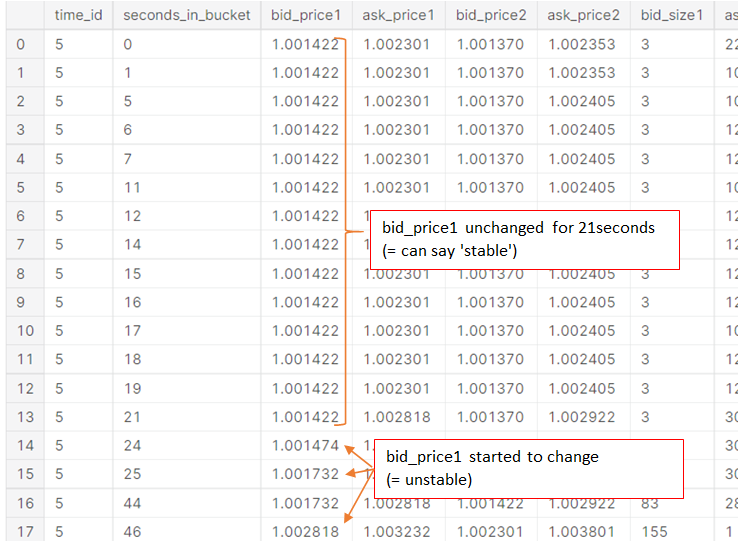

In [ ]:
def pre_process1_stability(df):
    df['bid1_diff'] = df.bid_price1.diff()
    df['ask1_diff'] = df.ask_price1.diff()
    df.loc[df['bid1_diff'].isnull(), 'bid1_diff'] = 0
    df.loc[df['ask1_diff'].isnull(), 'ask1_diff'] = 0
    return df

pre_process1_stability(book_train_df)
book_train_df.head()

Try to execute LightGBM and submit again, using these new features.....then, pubic score shows **1.17477**.
Quite improved. OK,OK :-)

これら新しい特徴量を使って、再度LightGBMに掛けると。。。スコアは、**1.17477**。結構改善した。よしよし。

**(5) 1.17477 --> 1.15836**

it could be said that Market tends to be unstable when the gap between Bid price and Ask price is large. Try to add this as a new feature. Public score was slightly improved to 1.15836. 

BidとAskの差が大きいとその分荒れやすいのかもしれない。Bid priceとAsk priceの差も特徴量に加えてみる。1.15836に小幅改善。

**(6) 1.15836 --> 0.90530**

Though gradually improved so far, score is still over 1.0 and almost near to the worst in the leaderboard. Now it may be a time to try more drastic method. What to do first is to use all stock_ids, though I purpposely used stock_id=0 only since I always encounter memory-over error when use all stocks. However, I noticed I could use a convenient method 'Parallel / delayed' when I refered to Raj Gandhi' notebook. Try this.

これまで改善を繰り返してきたものの、それでもまだ1.0を超えておりLeaderboardでは最下位に近い。このあたりで、特徴量以外の根本的な手を打つべきかも。まずやるべきは、対象をStock_id=0だけに絞っていたこと。纏めて全てのStock_idを対象にすると必ずメモリーオーバーエラーとなることから0だけに絞っていたが、Raj GandhiさんのNotebookを見て、Parallel処理をする便利な手法があることを知った。これを試してみる。


In [ ]:
# def get_group_features(stock_ids : list, dataType = 'train'):

#    preprocess_df = Parallel(n_jobs=-1)(
#        delayed(preprocess)(stock_id, dataType) 
#        for stock_id in stock_ids
#    )
    
#    group_features_df = pd.concat(preprocess_df, ignore_index = True)

#    return group_features_df

Public score was improved to **0.90530**. Wow, score became under1.0 ! Ok,Ok, :-)

スコアは**0.90530**と、初めて1.0を切った。良しよし。

**(7) 0.90530 --> 0.77856**

Next, try to use Trade information. Not only price presentation but also actual trade information may be an important factor.

次に、これまで使っていなかったTrade情報を使ってみる。Priceの提示だけしていても実際にDealが成立しているかどうかは大きな要素だしね。

In [ ]:
#  trade_df =  pd.read_parquet(f'../input/optiver-realized-volatility-prediction/trade_{dataset}.parquet/stock_id={stock_id}/')

#  trade_df['stock_id'] = stock_id
#  trade_df = trade_df.groupby(['stock_id', 'time_id']).agg(Price=('price', 'mean'),
#                                                            Size=('size', 'sum'),
#                                                            order_count=('order_count', 'sum'),
#                                                            trade_count=('order_count', 'count')).reset_index()
#    
#    group_features = group_features.merge(trade_df, on=['stock_id', 'time_id'], how='left')

The result of re-submission shows 0.77856. This is also a bit big improvement. Good.

再提出すると、スコアは0.77856へのそれなりに大きな改善。Good。


**(8) 0.77856 --> 0.59093**

It also may be good to use the count of price-change in every time_id(10 minutes). The result was, improved to **0.59093**. Quite good improvemet again.

「不安定さ」を示すのに、1time-id（10分間）の間に何回プライスが変わったか、の回数も有効かも。bid_Cntとask_Cntも特徴量に加えてみる。結果は**0.59093**へと、これまた比較的大きな改善。

**(9) 0.59093 --> 0.48964**

Any good method..??? Once sit down, let me check how target's hist shows??

他に手はないかなー。そういえば、Targetって、どういうHistになっているんだろう？

In [ ]:
train["target"].plot.hist(bins=20)

There seems a room to improve. Try to take a log.

これは改善のよちありそう。対数（log）をとってみる。

In [ ]:
np.log(train["target"]).plot.hist(bins=20)

As expected ! Let's use target after taking log :-)　The result was, improved to **0.48964**. OK!!


やっぱりね。targetはLogしたものを使おう。結果は**0.48964**へと改善。ＯＫ！


**(10) 0.48964 --> 0.43887**

Let's last try! Try to use Bid2, Ask2 which were not used so far. Add diff of bid1-bid2 and ask2-ask1 as a feature.
Improved from 0.48964 to 0.43887 :-)

After all, my notebook became as follows.

最後にもう一押し。これまでつかっていなかったBid2、Ask2を使ってみました。Bid1-Bid2、Ask2-Ask1のDiffを特徴量に追加。
0.43887に改善しました。

**(11) Try to use popular 'wap' instead of my 'impact'　--> not improved!**

Trying further improvement, I re-consider whether or not my own idea 'impact1' is really correct. Having a look at others' Notebook, I noticed 'wap' is popular, which is bid1_price * ask_size1, when calculate bid/ask price and size. Honestly, I'm not sure why bid_price and ask_size should be multipled... In my own idea 'impact1', simply 'bid_price' and 'bid_size' are multipled. But, let's try to use 'wap' instead of 'impact1'!! ... but result of public score is 0.46991...Got worse.. My original idea 'impact1' looks better than popular 'wap', though I'm not confident...

さらなる改善ができないかと考え、我流で使っている「impact1」という特徴量は本当に正しいか考えてみた。bid/ask priceとsizeをどう組み合わせるかという問題で、他のNotebookでは、bid1_price * ask_size1というように、何故かpriceとsizeの掛け算をするときにbidとaskを逆にして「wap」として使っている。一方、我流のimpact1は、bid1_price * bid1_sizeというように、priceもsizeも同じbidのものを使っている。実は、一般的に何故bidとaskを逆にしたものをつかっているのか理由がよくわからない。。ただ、ものは試しにということで、我流のimpact1の代わりにwap1というものをつかってみた。結果は、0.43887-->0.46991へと悪化。手前味噌で恐縮ですが、やっぱり我流のimpact1が良さそう。

**ということで、これまでの結果、Notebookは以下のようになりました。**

In [ ]:
book_train_df = book_train
train_df = train

In [ ]:
train_df["target"] = np.log(train_df["target"])

In [ ]:
train_df['row_id'] = train_df['stock_id'].astype(str) + '-' + train_df['time_id'].astype(str)

In [ ]:
train_df

In [ ]:
def pre_process1_impact1(df):
    df['bid_impact1'] = df.bid_price1 * df.bid_size1
    df['ask_impact1'] = df.ask_price1 * df.ask_size1
    df["impact_bid"] = (df.bid_impact1 - df.ask_impact1) / (df.bid_size1 + df.ask_size1)
    df["impact_ask"] = (df.ask_impact1 - df.bid_impact1) / (df.bid_size1 + df.ask_size1)
    df.loc[df['impact_bid']<0, "impact_bid"] = 0
    df.loc[df['impact_ask']<0, "impact_ask"] = 0
    df["impact1"] = df.impact_bid - df.impact_ask
    df.drop(['bid_impact1', 'ask_impact1', 'impact_bid', 'impact_ask'], axis =1, inplace =True)
    
    return df

In [ ]:
def pre_process1_stability(df):
    df['bid1_diff'] = df.bid_price1.diff()
    df['ask1_diff'] = df.ask_price1.diff()
    df.loc[df['bid1_diff'].isnull(), 'bid1_diff'] = 0
    df.loc[df['ask1_diff'].isnull(), 'ask1_diff'] = 0
    df['bid_ask_gap1'] = df.ask1_diff - df.bid1_diff
    return df

In [ ]:
def pre_process1_spread(df):
    
    df['bid_price_spread'] = df.bid_price1 - df.bid_price2
    df['ask_price_spread'] = df.ask_price2 - df.ask_price1
    
    df['bid_spread_diff'] = df.bid_price_spread.diff()
    df['ask_spread_diff'] = df.ask_price_spread.diff()
    
    df.loc[df['bid_spread_diff'].isnull(), 'bid_spread_diff'] = 0
    df.loc[df['ask_spread_diff'].isnull(), 'ask_spread_diff'] = 0
    
    df.drop(['bid_price_spread', 'ask_price_spread'], axis =1, inplace =True)
    
    return df

In [ ]:
def preprocess(stock_id, dataset):
    #book
    book_df = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_{dataset}.parquet/stock_id={stock_id}/')
    book_df['stock_id'] = stock_id
    
    pre_process1_impact1(book_df)
    pre_process1_stability(book_df)
    pre_process1_spread(book_df)
    
    group_features = book_df.groupby(['stock_id','time_id']).agg(impact1=('impact1', 'mean'),                                                                 
                                                                 bid1_diff=('bid1_diff', 'mean'),
                                                                 ask1_diff=('ask1_diff', 'mean'),                                                                 
                                                                 bid_Cnt = ('bid_price1', 'nunique'),
                                                                 ask_Cnt = ('ask_price1', 'nunique'),
                                                                 bid_ask_gap1=('bid_ask_gap1', 'mean'),
                                                                 bid_spread_diff=('bid_spread_diff', 'mean'),
                                                                 ask_spread_diff=('ask_spread_diff', 'mean')
                                                                ).reset_index()
        
    #trade
    trade_df =  pd.read_parquet(f'../input/optiver-realized-volatility-prediction/trade_{dataset}.parquet/stock_id={stock_id}/')
    trade_df['stock_id'] = stock_id
    trade_df = trade_df.groupby(['stock_id', 'time_id']).agg(Price=('price', 'mean'),
                                                            Size=('size', 'sum'),
                                                            order_count=('order_count', 'sum'),
                                                            trade_count=('order_count', 'count')).reset_index()
    
    group_features = group_features.merge(trade_df, on=['stock_id', 'time_id'], how='left')
    
    return group_features

In [ ]:
def get_group_features(stock_ids : list, dataType = 'train'):

    preprocess_df = Parallel(n_jobs=-1)(
        delayed(preprocess)(stock_id, dataType) 
        for stock_id in stock_ids
    )
    
    group_features_df = pd.concat(preprocess_df, ignore_index = True)

    return group_features_df

In [ ]:
%%time

stock_ids = list(train['stock_id'].unique())
group_features_df = get_group_features(stock_ids, 'train')

train_df = pd.merge(train_df, group_features_df, on = ['stock_id', 'time_id'], how ='left')
train_df

In [ ]:
group_features_df

In [ ]:
train_df["row_id"] = train_df["row_id"].astype('category')

X_train = train_df.drop(['target'], axis=1)
Y_train = train_df['target']

In [ ]:
kf = KFold(n_splits = 3)
models = []
rmspes =[]
lgbm_params ={"objective":"regression",
              "random_seed":1234,
              'num_leaves': 35,
              'max_bin': 83,
              'feature_fraction': 0.44892224224701704,
              'bagging_fraction': 0.8310957587108416,
              'bagging_freq': 10,
              'min_data_in_leaf': 16,
              'min_sum_hessian_in_leaf': 10}
categories = ["row_id", "stock_id"]

for train_index, val_index in kf.split(X_train):
    XX_train = X_train.iloc[train_index]
    XX_valid = X_train.iloc[val_index]
    YY_train = Y_train.iloc[train_index]
    YY_valid = Y_train.iloc[val_index]
    
    lgbm_train = lgbm.Dataset(XX_train, YY_train, categorical_feature = categories)
    lgbm_eval = lgbm.Dataset(XX_valid, YY_valid, categorical_feature = categories, reference=lgbm_train)
    
    model_lgbm = lgbm.train(lgbm_params,
                           lgbm_train,
                           valid_sets = lgbm_eval,
                           num_boost_round = 100,
                           early_stopping_rounds = 20,
                           verbose_eval = 10,
                           )
    y_pred = model_lgbm.predict(XX_valid, num_iteration = model_lgbm.best_iteration)
    
    tmp_rmspe = np.sqrt(np.mean(np.square((YY_valid - y_pred) / YY_valid)))
    print (tmp_rmspe)
    
    models.append(model_lgbm)
    rmspes.append(tmp_rmspe)

In [ ]:
test_df = test
book_test_df = book_test

test_df

In [ ]:
stock_ids = list(test_df['stock_id'].unique())
group_features_df = get_group_features(stock_ids, 'test')

test_df = pd.merge(test_df, group_features_df, on = ['stock_id', 'time_id'], how ='left')
test_df

In [ ]:
test_df["row_id"] = test_df["row_id"].astype('category')

X_test = test_df
X_test

In [ ]:
preds = []

for model in models:
    pred = model.predict(X_test)
    preds.append(pred)
    
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis =0)

preds_mean = np.exp(preds_mean)

preds_mean

In [ ]:
sub = pd.read_csv('../input/optiver-realized-volatility-prediction/sample_submission.csv')
sub['target']=0.00000000
sub['target'] = preds_mean

sub.to_csv('submission.csv',index=False)
sub